<h1><center> MDS7203 - Proyecto Final <br /> Generative Models: Wassesrtein Generative Adversarial Networks <br/> </center></h1>
<h3><center>Profesor: Felipe Tobar <br />
Profesor Auxiliar: Camilo Carvajal y Cristobal Alcazar <br />
<h3><center>Semestre: Primavera 2023 </center></h3>

<h2> Conditional Convolutional GAN (CCGAN) </h2>

In [1]:
from tqdm import tqdm
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
torch.manual_seed(0); # Set for testing purposes, please do not change!

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
is_train = False#Variable booleana que indica si es entrenamiento o no

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), save=False, name=None, epoch=None):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    if save:
        plt.savefig('{}_epoch_{}.png'.format(name, epoch))
    plt.show()

<h3> Bloque del Generador </h3>

La estructura de cada bloque es la siguiente:
*   Una capa deconvolucional
*   Una capa de batchnorm, salvo en la última capa
*   Una activación ReLU después de cada batchnorm
*   Una activacion Tanh, sólo para la última capa

In [4]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh()
        )

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

<h2> Generador</h2>



In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.embed = nn.Embedding(10, z_dim)
        self.gen = nn.Sequential(
            make_gen_block(z_dim, hidden_dim * 4, kernel_size=3, stride=2),
            make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2),
            make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, final_layer=True),
        )

    def vec_reshape(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def get_emb(self, labels):
        return self.vec_reshape(self.embed(labels))

    def forward(self, noise, labels=None):
        x = self.vec_reshape(noise)
        if labels is not None: x = x * self.get_emb(labels)
        return self.gen(x)

    def intepolation(self, label1, label2, n_samples=10, device='cpu'):
        if not isinstance(label1, torch.Tensor): label1 = torch.tensor(label1, device=device).view(1, 1)
        if not isinstance(label2, torch.Tensor): label2 = torch.tensor(label2, device=device).view(1, 1)
        noise = get_noise(n_samples, self.z_dim, device=device)
        label1 = self.get_emb(label1).squeeze()
        label2 = self.get_emb(label2).squeeze()
        inter_vecs = torch.zeros(n_samples, self.z_dim, device=device)
        for i in range(n_samples):
            inter_vecs[i] = label1 + (label2 - label1) * i / (n_samples - 1)
        return self.forward(inter_vecs * noise)

<h2> Tests Generador </h2>

In [7]:
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.vec_reshape(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.vec_reshape(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.vec_reshape(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [8]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Well done !")

Well done !


<h3> Bloque del discriminador</h3>

Procederemos a implementar un bloque para el discriminador.
La estructura de cada bloque es la siguiente:

*    Una capa convolucional
*    Una capa de batchnorm, excepto por la última capa
*    Una activacion LeakyReLU de pendiente 0.2, sólo después de las capas de batchnorm

In [9]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

<h2> Discriminador </h2>



In [10]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()

        self.im_size = 28*28
        self.embed = nn.Embedding(10, self.im_size)

        self.disc = nn.Sequential(
            make_disc_block(im_chan, hidden_dim, kernel_size=4, stride=2),
            make_disc_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2),
            make_disc_block(hidden_dim * 2, 1, kernel_size=4, stride=2, final_layer=True),
        )

    def vec_reshape(self, vec):
        return vec.view(len(vec), 1, 28, 28)

    def get_emb(self, labels):
        return self.vec_reshape(self.embed(labels))

    def forward(self, image, labels = None):
        if labels is not None: image = image * self.get_emb(labels)
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<h2> Test Discriminador </h2>

In [11]:
num_test = 100

gen = Generator().to(device)
disc = Discriminator().to(device)
noise = get_noise(num_test, gen.z_dim, device=device)
labels = torch.randint(0, 10, (num_test,), device=device)
print(noise.shape)
print(labels.shape)
test_images = gen(noise, labels).to(device)

# Test the hidden block
test_hidden_block = make_disc_block(1, 5, kernel_size=6, stride=3).to(device)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True).to(device)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

torch.Size([100, 10])
torch.Size([100])


In [12]:
# UNIT TESTS
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Well done !")

Well done !


A continuación se definen los parámetros de entrenamiento a utlizar, y una funcion de utilidad para la inicialización de los pesos.

In [13]:
# Setting the training parameters
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 177375322.08it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 18789467.01it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 66502152.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9870740.29it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [14]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

<h2> Wasserstein  Conditional GAN with Gradient Penalty (WCGAN-GP) </h2>

Hasta el momento se implementó un modelo genérico de CCGAN, el factor que lo vuelve una WCGAN-GP es la definicion de su funcion de loss
 que resuelve alguno de los problemas de estabilidad en el entrenamiento de GANs. <br>En este modelo, se modifica la loss estándar que era una adaptacion de una Binary Cross Entropy por la W-loss correspondiente a una distancia de Wasserstein, y se agrega un término de penalización por gradiente que ayuda a prevenir el problema del <i>mode collapse</i>.

Debido a que los cambios del modelo son hechos a la loss, es posible utilizar el mismo Generador y Discriminador de la CCGAN. <br>En esta ocasión, el discriminador pasará a llamarse crítico, por su función de entregar valores reales a cada uno de los ejemplos presentados, en vez de clasificarlos como real/falso.

Comenzaremos por definir una función de utilidad para poder hacer seguimiento de los valores del gradiente, e inicializar nuevamente los pesos.

In [15]:
def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [16]:
# New training parameters
n_epochs = 100
display_step = 50
c_lambda = 10
crit_repeats = 5

In [17]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Discriminator().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty

La loss del discriminador requerirá de un término adicional de penalización.
Este corresponde a
$ \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}}[ (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 ]$

Para ello se realizaron los siguientes pasos:
   - Calcular $\hat{x}$, un promedio ponderado entre imágenes reales y falsas: $\hat{\mathbf{x}} = \epsilon \mathbf{x} + (1-\epsilon)G(\mathbf{z})$, siendo $\epsilon$ escogido aleatoriamente entre 0 y 1
   - Calcular el <i> score </i> entregado por el crítico a $\hat{x}$
   - Calcular el gradiente.
   - Computar el término de gradient penalty.

In [18]:
def get_gradient(crit_model, real_images, fake_images, epsilon, labels):

    mixed_images = real_images * epsilon + fake_images * (1 - epsilon)
    mixed_scores = crit_model(mixed_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with how the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [19]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    labels = torch.randint(0, 10, (image_shape[0],), device=device)
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon, labels)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Well done !")

Well done !


Una vez definido el gradiente, se definió el método `gradient_penalty` para calcular el término completo de penalización de gradiente, dado los gradientes



In [20]:
def gradient_penalty(gradient):

    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [21]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Well done !")

Well done !


## Losses

En una WCGAN-GP, el discriminador se utiliza para aproximar la distancia de Wasserstein, la cual está dada por la expresión:  

$\mathbb{W} \approx \displaystyle \mathop{\mathbb{E }}_{{\mathbf{x}}}[D(\mathbf{x})] - \displaystyle \mathop{\mathbb{E }}_{\mathbf{x}'=G(\mathbf{z})} [D(G(\mathbf{z}))] + \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}} \lambda (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 $

Para ello se implementaron los métodos `get_gen_wloss` y `get_crit_wloss` que devuelvan $L_{D}$ y $L_{G}$, los cuales serán utilizados para maximizar y minimizar $\mathbb{W}$, respectivamente.

In [22]:
def get_gen_wloss(crit_fake_pred):
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

In [23]:
# UNIT TEST
assert torch.isclose(
    get_gen_wloss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_wloss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Well done !")

Well done !


In [24]:
def get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [25]:
# UNIT TEST
assert torch.isclose(
    get_crit_wloss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_wloss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Well done !")

Well done !


## Entrenamiento WCGAN-GP


El entrenamiento es más lento debido a que en cada iteración se debe calcular el término de penalización de gradiente, lo cual requiere de un cálculo adicional de la función de pérdida del discriminador, por lo que el entrenamiento es más lento.

Además, notar que en el entrenamiento, se realizan varias actualizaiciones del crítico por actualizaciones del generador para intentar compensar por la regularizacion aplicada, y que el generador no gane fácilmente el juego.

Finalmente, si bien la WCGAN-GP podría no ser mejor en cuanto calidad de imágenes generadas, mejora significativamente la estabilidad del entrenamiento y evita el <i> mode collapse </i>. Por esto, debería poder entrenar una WGAN-GP por muchas épocas sin sufrir de este problema.

In [ ]:
if is_train:
    cur_step = 0
    generator_losses = []
    critic_losses = []
    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            real = real.to(device)
            labels = labels.to(device)
            mean_iteration_critic_loss = 0
            for _ in range(crit_repeats):
                # Update critic
                crit_opt.zero_grad()
                fake_noise = get_noise(cur_batch_size, z_dim, device=device)
                fake = gen(fake_noise, labels)
                crit_real_pred = crit(real, labels.detach())
                crit_fake_pred = crit(fake.detach(), labels.detach())
                epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
                gradient = get_gradient(crit, real, fake.detach(), epsilon,labels)
                gp = gradient_penalty(gradient)
                crit_loss = get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda)
                mean_iteration_critic_loss += crit_loss.item() / crit_repeats
                # Update gradients
                crit_loss.backward(retain_graph=True)
                # Update optimizer
                crit_opt.step()
            critic_losses += [mean_iteration_critic_loss]

            # Update generator
            gen_opt.zero_grad()
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
            fake_2 = gen(fake_noise_2, labels)
            crit_fake_pred = crit(fake_2, labels)

            gen_loss = get_gen_wloss(crit_fake_pred)
            gen_loss.backward()

            # Update the weights
            gen_opt.step()

            generator_losses += [gen_loss.item()]

            # Visualization code
            if cur_step % display_step == 0 and cur_step > 0:
                display.clear_output(wait=True)
                gen_mean = sum(generator_losses[-display_step:]) / display_step
                crit_mean = sum(critic_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
                show_tensor_images(fake, save=True, name='wgangp')
                show_tensor_images(real)
                step_bins = 20
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins),
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins),
                    torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Critic Loss"
                )
                plt.legend()
                plt.show()

            cur_step += 1

In [ ]:
# Guardar loss
# torch.save(generator_losses, 'generator_losses_wgangp')
# torch.save(critic_losses, 'critic_losses_wgangp')

In [26]:
# Cargar loss
if not is_train:
    generator_losses = torch.load('generator_losses_wgangp.unknown')
    critic_losses = torch.load('critic_losses_wgangp.unknown')
    gen.load_state_dict(torch.load('wcgangp.unknown', map_location=torch.device(device)))

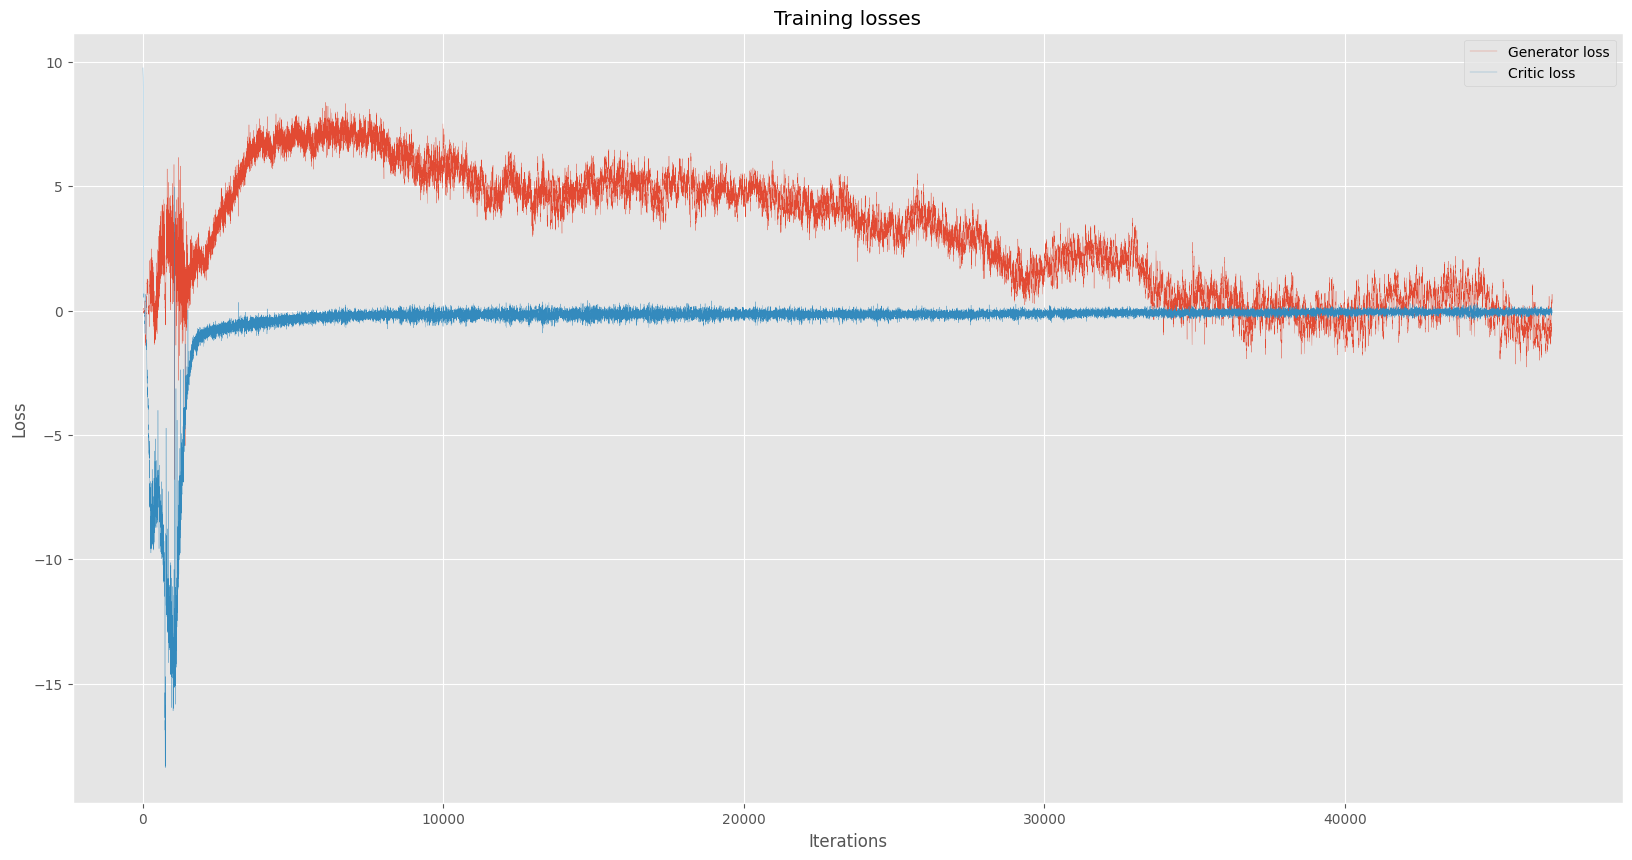

In [27]:
# Improving the visualizations
plt.style.use('ggplot')

# Plot generator and critic loss (15, 20)
plt.subplots(figsize=(20, 10))
# Linea delgada
plt.plot(generator_losses, label='Generator loss', linewidth=0.2)
plt.plot(critic_losses, label='Critic loss', linewidth=0.2)
plt.title("Training losses")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()

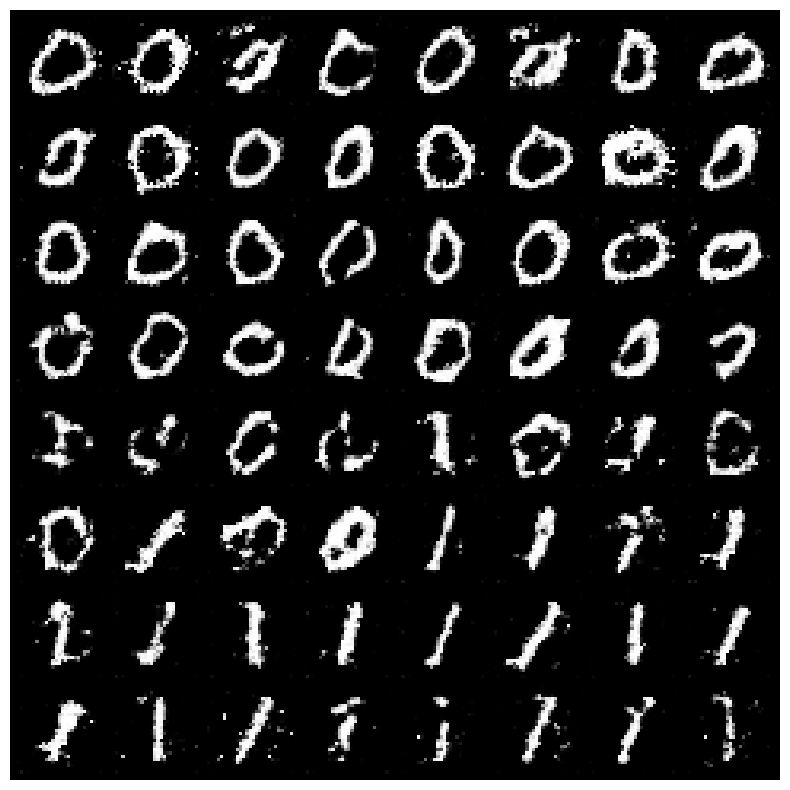

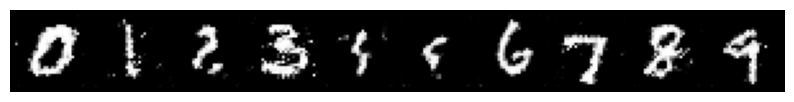

In [28]:
# Generar más imágenes
n_interpolation = 64
interpolation = gen.intepolation(0, 1, n_interpolation, device=device)
import numpy as np
# Plot the generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(
    np.transpose(
        make_grid(interpolation, padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)
# Generar solo 1
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(
    np.transpose(
        make_grid(gen(get_noise(10, z_dim, device=device), torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device)), nrow = 10, padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)

<h2> Evaluación : Fréchet Inception Distance </h2>

In [30]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=bc7d75d1715888d12a4cd82077627e304c953eceaf32384788f21d89329d568e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [31]:
import wget
import os
import seaborn as sns

filename = 'inception_v3_google-1a9a5a14.pth'
url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'

if not os.path.exists(filename):
    wget.download(url)

In [32]:
from torchvision.models import inception_v3

inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load(filename))
inception_model.to(device)
inception_model = inception_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


**Formula**

Basado en el paper "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" la distancia de Fréchet entre dos distribuciones gaussianas multivariadas $X$ and $Y$ es:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

In [33]:
import scipy

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [34]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    fd = torch.norm(mu_x - mu_y)**2 + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))
    return fd

In [35]:
# UNIT TESTS

from torch.distributions import MultivariateNormal

mean1 = torch.Tensor([0, 0])
covariance1 = torch.Tensor(
    [[1, 0],
     [0, 1]]
)
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0])
covariance2 = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(
    frechet_distance(
        dist1.mean, dist2.mean,
        dist1.covariance_matrix, dist2.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

assert (frechet_distance(
        dist1.mean, dist1.mean,
        dist1.covariance_matrix, dist1.covariance_matrix
    ).item() == 0)

print("Well done !")

Well done !


Para usar la función `frechet_distance`, se crea el método `get_covariance` el cual entrega la matriz de covarianza a partir de una lista de features.

In [36]:
import numpy as np

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Finalmente, se utilizará el modelo Inception-v3 pre-entrenado para calcular los features en imágenes reales y generadas, para luego obtener la métrica de FID de los dos modelos entrenados con anterioridad.

In [37]:
fake_features_list = []
real_features_list = []
fake_baseline_features_list = []
real_baseline_features_list = []

gen.eval()
n_samples = 10000 # The total number of samples
batch_size = 64 # Samples per iteration

dataloader = DataLoader(MNIST('.', download=False, transform=transform),
                        batch_size=batch_size,
                        shuffle=True)

def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    img = img.repeat(1,3,1,1)
    return img

def compute_features(gen, baseline = False):
    cur_samples = 0
    with torch.no_grad():
        if not baseline:
            print("Computing features...")
            for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):
                print("Computing features loop...")
                real_samples = preprocess(real_example)
                real_features = inception_model(real_samples.to(device)).detach().to('cpu')
                real_features_list.append(real_features)

                fake_samples = get_noise(len(real_example), z_dim).to(device)
                fake_samples = preprocess(gen(fake_samples))
                fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
                fake_features_list.append(fake_features)
                cur_samples += len(real_samples)
                print(cur_samples)
                if cur_samples >= n_samples:
                    return real_features_list, fake_features_list
        else:
            print("Computing features...")
            for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):
                print("Computing features loop...")
                real_samples = preprocess(real_example)
                real_features = inception_model(real_samples.to(device)).detach().to('cpu')
                real_baseline_features_list.append(real_features)

                fake_samples = get_noise(len(real_example), z_dim).to(device)
                fake_samples = preprocess(baseline_gen(fake_samples))
                fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
                fake_baseline_features_list.append(fake_features)
                cur_samples += len(real_samples)
                print(cur_samples)
                if cur_samples >= n_samples:
                    return real_baseline_features_list, fake_baseline_features_list


        # except:
        #     print("Error in loop")

In [40]:
baseline_gen = Generator(z_dim).to(device)

In [41]:
fake_baseline_features_list, real_baseline_features_list = compute_features(baseline_gen, baseline = True)

Computing features...


  0%|          | 0/156 [00:00<?, ?it/s]

Computing features loop...
64
Computing features loop...
128
Computing features loop...
192
Computing features loop...
256
Computing features loop...
320
Computing features loop...
384
Computing features loop...
448
Computing features loop...
512
Computing features loop...
576
Computing features loop...
640
Computing features loop...
704
Computing features loop...
768
Computing features loop...
832
Computing features loop...
896
Computing features loop...
960
Computing features loop...
1024
Computing features loop...
1088
Computing features loop...
1152
Computing features loop...
1216
Computing features loop...
1280
Computing features loop...
1344
Computing features loop...
1408
Computing features loop...
1472
Computing features loop...
1536
Computing features loop...
1600
Computing features loop...
1664
Computing features loop...
1728
Computing features loop...
1792
Computing features loop...
1856
Computing features loop...
1920
Computing features loop...
1984
Computing features loop.

In [ ]:
fake_features_list, real_features_list = compute_features(gen)

Computing features...


  0%|          | 0/156 [00:00<?, ?it/s]

Computing features loop...
64
Computing features loop...
128
Computing features loop...
192
Computing features loop...
256
Computing features loop...
320
Computing features loop...
384
Computing features loop...
448
Computing features loop...
512
Computing features loop...
576
Computing features loop...
640
Computing features loop...
704
Computing features loop...
768
Computing features loop...
832
Computing features loop...
896
Computing features loop...
960
Computing features loop...
1024
Computing features loop...
1088
Computing features loop...
1152
Computing features loop...
1216
Computing features loop...
1280
Computing features loop...
1344
Computing features loop...
1408
Computing features loop...
1472
Computing features loop...
1536
Computing features loop...
1600
Computing features loop...
1664
Computing features loop...
1728
Computing features loop...
1792
Computing features loop...
1856
Computing features loop...
1920
Computing features loop...
1984
Computing features loop.

In [47]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [48]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

471.77435302734375


In [ ]:
fake_baseline_features_all = torch.cat(fake_baseline_features_list)
real_baseline_features_all = torch.cat(real_baseline_features_list)

baseline_mu_fake = torch.mean(fake_baseline_features_all, dim=0)
baseline_mu_real = torch.mean(real_baseline_features_all, dim=0)
baseline_sigma_fake = get_covariance(fake_baseline_features_all)
baseline_sigma_real = get_covariance(real_baseline_features_all)

In [46]:
with torch.no_grad():
    print(frechet_distance(baseline_mu_real, baseline_mu_fake, baseline_sigma_real, baseline_sigma_fake).item())

1747.8985595703125
